In [57]:
!pip install xgboost

                                              0.0/124.9 MB ? eta -:--:--
                                              0.1/124.9 MB 4.3 MB/s eta 0:00:30
                                              0.6/124.9 MB 7.0 MB/s eta 0:00:18
                                             1.3/124.9 MB 10.2 MB/s eta 0:00:13
                                             2.0/124.9 MB 11.5 MB/s eta 0:00:11
                                             2.9/124.9 MB 13.2 MB/s eta 0:00:10
     -                                       3.6/124.9 MB 13.7 MB/s eta 0:00:09
     -                                       4.4/124.9 MB 14.0 MB/s eta 0:00:09
     -                                       5.3/124.9 MB 14.7 MB/s eta 0:00:09
     -                                       6.1/124.9 MB 15.0 MB/s eta 0:00:08
     --                                      6.7/124.9 MB 15.3 MB/s eta 0:00:08
     --                                      7.8/124.9 MB 15.7 MB/s eta 0:00:08
     --                                      9.

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import trim_mean
from statsmodels.robust.scale import mad
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [78]:
df = pd.read_csv("HR Dat Set.csv")
df.head()

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,3,80,0,0,2,3,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,1,80,0,0,2,3,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,4,80,0,0,3,3,0,0,0,0.0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,4,80,0,0,2,3,0,0,0,0.0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,4,80,0,0,0,3,0,0,0,0.0


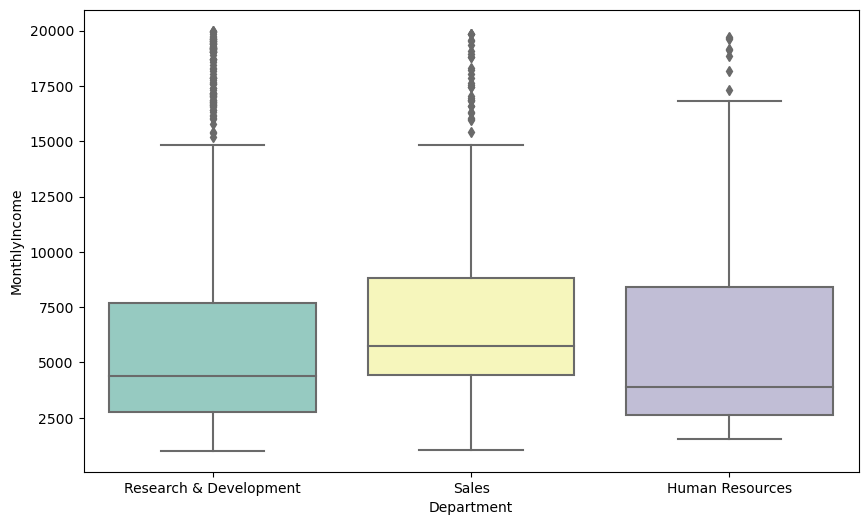

In [4]:
plt.figure(figsize = (10,6))
sns.boxplot(data = df, x = "Department", y = "MonthlyIncome", palette = "Set3")
plt.show()

Centre of Location Assesment 

In [168]:
mean_dept = df.groupby("Department")["MonthlyIncome"].mean()
trim_mean_dept = df.groupby("Department")["MonthlyIncome"].apply(lambda x: trim_mean(x, 0.1))
median = df.groupby("Department")["MonthlyIncome"].median()
def weighted_mean(x):
    return np.average(x['MonthlyIncome'], weights=x['YearsInCurrentRole'])
weighted_mean = df.groupby('Department').apply(weighted_mean)

In [169]:
summary_table = pd.DataFrame({
    "Mean": mean_dept,
    "Trimmed Mean (10%)": trim_mean_dept,
    "Median": median,
    "Weighted Mean":weighted_mean
})

In [170]:
summary_table

,Mean,Trimmed Mean (10%),Median,Weighted Mean
Department,,,,
Human Resources,6654.507937,5705.098039,3886.0,8172.336323
Research & Development,6280.365047,5365.569032,4377.0,7864.174346
Sales,6966.737778,6387.755556,5754.5,8154.326238


Percentile Distribution across the departments

In [8]:
quantile = [0.1,0.25,0.5,0.75,0.95]
df.groupby("Department")["MonthlyIncome"].quantile(quantile).unstack(level = -1)

,0.10,0.25,0.50,0.75,0.95
Department,,,,,
Human Resources,2153.8,2644.00,3886.0,8412.50,19184.20
Research & Development,2286.8,2741.00,4377.0,7690.00,18019.90
Sales,2653.9,4446.25,5754.5,8822.75,16731.95


In [9]:
# Calculate percentiles
df['Percentile'] = df.groupby(['JobRole', 'PerformanceRating'])['MonthlyIncome'].rank(pct=True) * 100
# Aggregate salary information
salary_distribution = df.groupby(['JobRole', 'PerformanceRating'])['MonthlyIncome'].describe(percentiles=[0.25, 0.5, 0.75]).reset_index()


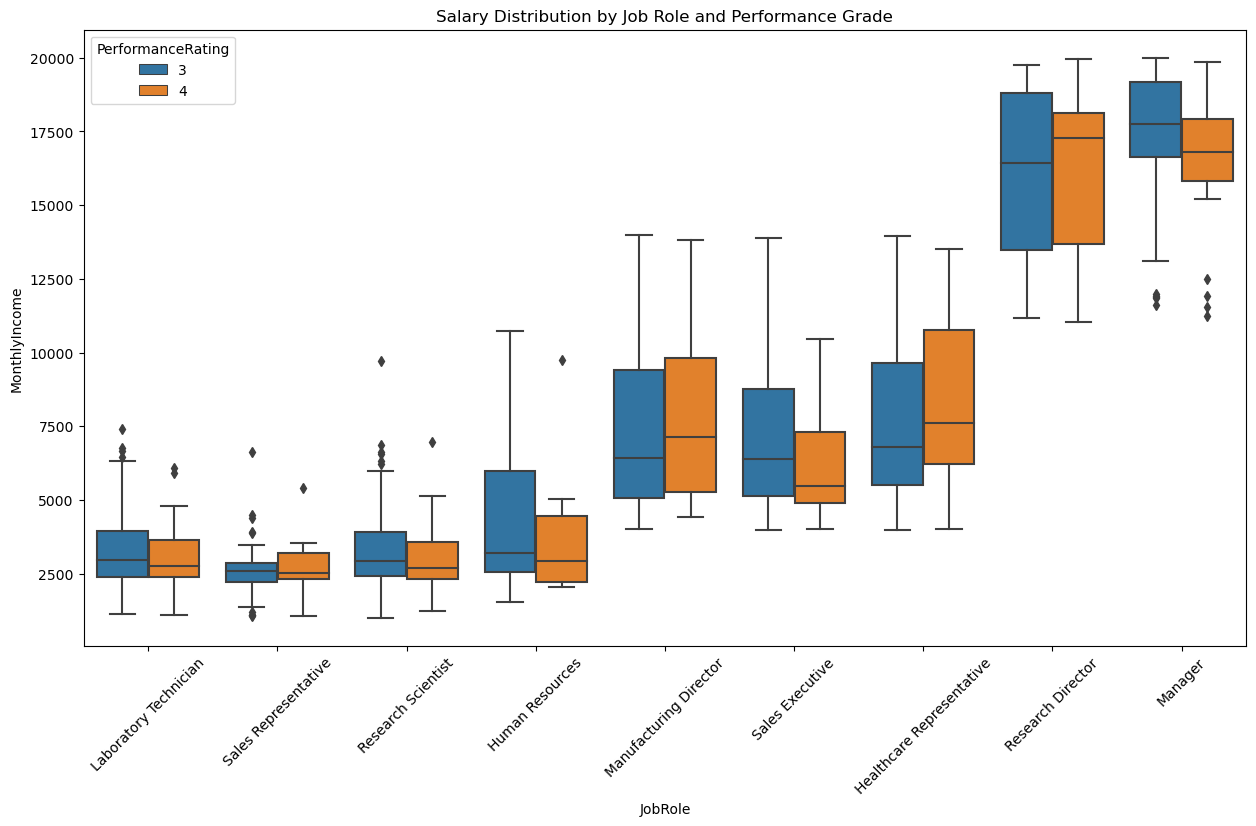

In [10]:
# Boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(x='JobRole', y='MonthlyIncome', hue='PerformanceRating', data=df)
plt.title('Salary Distribution by Job Role and Performance Grade')
plt.xticks(rotation=45)
plt.show()


## Building and Training a Linear Regression Model

In [11]:
X = df[['JobRole','PerformanceRating','YearsInCurrentRole','YearsAtCompany','TotalWorkingYears']]
y = df[["MonthlyIncome"]]

Here:
        MonthlyIncome = f(JobRole,PerformanceRating,YearsInCurrentRole,YearsAtCompany,TotalWorkingYears)
       

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('onehot',OneHotEncoder(drop = 'first'),[0])],remainder = 'passthrough')
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [14]:
# Scaling / Standardization of the Data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Elastic

In [15]:
elastic = ElasticNet()
elastic.fit(X_train_scaled, y_train)
y_pred_elastic = elastic.predict(X_test_scaled)

In [16]:
mae_elastic = mean_absolute_error(y_test,y_pred_elastic)
score_elastic = r2_score(y_test,y_pred_elastic)
print("MAE:", mae_elastic)
print("Score:", score_elastic)

MAE: 1547.8697982603967
Score: 0.8325082581361828


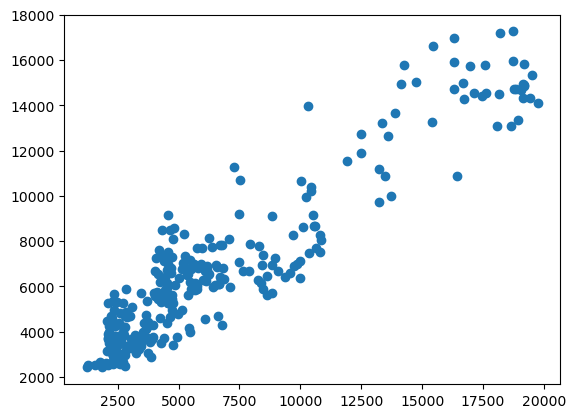

In [17]:
plt.scatter(y_test,y_pred_elastic)

## Ridge Regression

In [18]:
from sklearn.linear_model import Ridge 

In [19]:
ridge=Ridge()
ridge.fit(X_train_scaled,y_train)
y_pred_ridge=ridge.predict(X_test_scaled)

In [20]:
mae_ridge = mean_absolute_error(y_test,y_pred_ridge)
score_ridge = r2_score(y_test,y_pred_ridge)
print("MAE:", mae_ridge)
print("Score:", score_ridge)

MAE: 1321.147499357121
Score: 0.8802956923928571


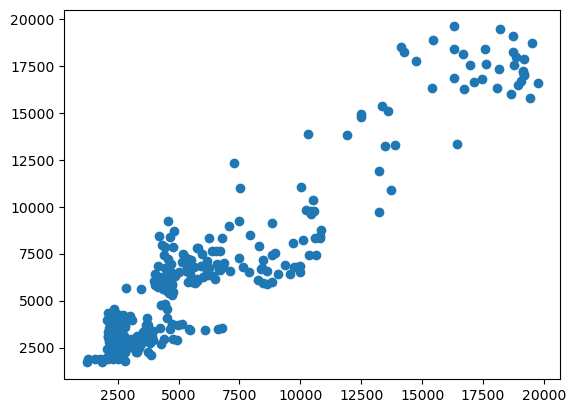

In [21]:
plt.scatter(y_test,y_pred_ridge)

## Lasso Regression

In [22]:
from sklearn.linear_model import Lasso 

In [23]:
lasso=Lasso()
lasso.fit(X_train_scaled,y_train)
y_pred_lasso=lasso.predict(X_test_scaled)

In [24]:
mae_lasso = mean_absolute_error(y_test,y_pred_lasso)
score_lasso = r2_score(y_test,y_pred_lasso)
print("MAE:", mae_lasso)
print("Score:", score_lasso)

MAE: 1320.9748207683701
Score: 0.8803324121520913


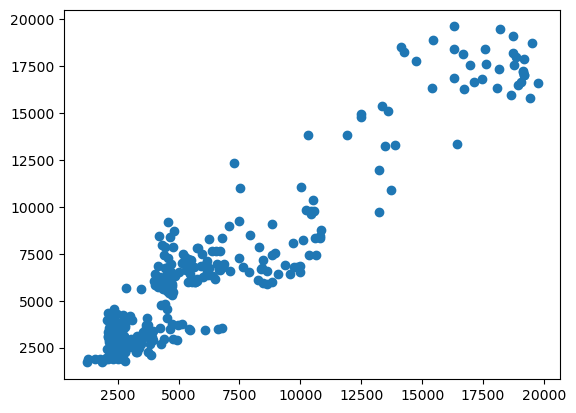

In [25]:
plt.scatter(y_test,y_pred_lasso)

### Checking for whether Cross Validated models yield any Better Results

In [26]:
from sklearn.linear_model import LassoCV

In [27]:
# Convert DataFrame to a 1D numpy array
y_train_ra = y_train.values.ravel()


In [28]:
lassocv=LassoCV(cv= 5)
lassocv.fit(X_train_scaled,y_train_ra)
y_pred_lassocv=lassocv.predict(X_test_scaled)

In [29]:
mae_lassocv = mean_absolute_error(y_test,y_pred_lassocv)
score_lassocv = r2_score(y_test,y_pred_lassocv)
print("MAE:", mae_lassocv)
print("Score:", score_lassocv)

MAE: 1319.867450034831
Score: 0.8806915075111563


In [30]:
from sklearn.linear_model import RidgeCV

In [31]:
ridgecv=RidgeCV(cv= 5)
ridgecv.fit(X_train_scaled,y_train_ra)
y_pred_ridgecv=ridgecv.predict(X_test_scaled)

In [32]:
mae_ridgecv = mean_absolute_error(y_test,y_pred_ridgecv)
score_ridgecv = r2_score(y_test,y_pred_ridgecv)
print("MAE:", mae_ridgecv)
print("Score:", score_ridgecv)

MAE: 1321.7234135620988
Score: 0.8803147690934885


In [33]:
from sklearn.linear_model import ElasticNetCV

In [34]:
elastic_cv=ElasticNetCV(cv= 5)
elastic_cv.fit(X_train_scaled,y_train_ra)
y_pred_elastic_cv=elastic_cv.predict(X_test_scaled)

In [35]:
mae_elastic_cv = mean_absolute_error(y_test,y_pred_elastic_cv)
score_elastic_cv = r2_score(y_test,y_pred_elastic_cv)
print("MAE:", mae_elastic_cv)
print("Score:", score_elastic_cv)

MAE: 2662.069519129817
Score: 0.5095577762824415


### Random Forest 

In [36]:
rf = RandomForestRegressor()

In [37]:
rf.fit(X_train_scaled, y_train_ra)

RandomForestRegressor()

In [38]:
rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

In [53]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
regressor = RandomForestRegressor()
grid = RandomizedSearchCV(regressor, rf_params, cv=3, scoring ='neg_mean_squared_error' )

In [54]:
import warnings 
warnings.filterwarnings('ignore')
grid.fit(X_train_scaled, y_train_ra)
y_pred_rf = grid.predict(X_test_scaled)

In [55]:
mae_elastic_rf = mean_absolute_error(y_test,y_pred_rf)
score_elastic_rf = r2_score(y_test,y_pred_rf)
print("MAE:", mae_elastic_rf)
print("Score:", score_elastic_rf)

MAE: 1175.7598744650054
Score: 0.8973000353020493


### XGBOOST

In [60]:
xgb = XGBRegressor()

In [61]:
xgb.fit(X_train_scaled, y_train_ra)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

In [73]:
regressor_xgb = XGBRegressor()
grid_xgb = RandomizedSearchCV(regressor_xgb,xgboost_params,n_iter = 100, cv=3, scoring ='neg_mean_squared_error' )

In [74]:
grid_xgb.fit(X_train_scaled,y_train_ra)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1, 0.3,
                                                             0.4],
                                        'learning_rate': [0.1, 0.01],
                                        'max_depth': [5, 8, 12, 20, 30],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_mean_squared_error')

In [75]:
y_pred_xgb = grid_xgb.predict(X_test_scaled)

In [76]:
mae_elastic_xgb = mean_absolute_error(y_test,y_pred_xgb)
score_elastic_xgb = r2_score(y_test,y_pred_xgb)
print("MAE:", mae_elastic_xgb)
print("Score:", score_elastic_xgb)

MAE: 1226.932667500264
Score: 0.8960504269113632


### Sorting for the Best model 

In [77]:
metrics = pd.DataFrame({
    "Model": ["Ridge", "Lasso", "ElasticNet","RidgeCV", "LassoCV", "ElasticNetCV","Random Forest","XGB"],
    "accuracy": [score_ridge, score_lasso, score_elastic,score_ridgecv, score_lassocv, score_elastic_cv,score_elastic_rf,score_elastic_xgb]
})
(metrics.sort_values("accuracy", ascending = False))

,Model,accuracy
6,Random Forest,0.897300
7,XGB,0.896050
4,LassoCV,0.880692
1,Lasso,0.880332
3,RidgeCV,0.880315
0,Ridge,0.880296
2,ElasticNet,0.832508
5,ElasticNetCV,0.509558


# Attrition Simulation 

In [171]:
X = df[['JobRole','PerformanceRating','YearsInCurrentRole','YearsAtCompany','TotalWorkingYears']]

In [79]:
# Using the same parameters above to predict the attrition
y_attr = df["Attrition"]
Z_train,Z_test,y_attr_train,y_attr_test = train_test_split(X,y_attr,test_size = 0.2, random_state = 42)

In [119]:
# Applying Column Transformer
ct = ColumnTransformer(transformers=[('onehot',OneHotEncoder(drop = 'first'),[0])],remainder = 'passthrough')
Z_train= ct.fit_transform(X_train)
Z_test = ct.transform(X_test)
Z_train_scaled = scaler.fit_transform(X_train)
Z_test_scaled = scaler.transform(X_test)

In [120]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_attr_train_encoded = le.fit_transform(y_attr_train)
y_attr_test_encoded = le.transform(y_attr_test)

## Logistic Regression 

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [96]:
model=LogisticRegression()
penalty=['l1', 'l2', 'elasticnet']
c_values=[100,10,1.0,0.1,0.01]
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
params=dict(penalty=penalty,C=c_values,solver=solver)

In [121]:
cv=StratifiedKFold()
grid=GridSearchCV(estimator=model,param_grid=params,scoring='accuracy',cv=5,n_jobs=-1)
grid.fit(Z_train_scaled,y_attr_train_encoded)
y_pred=grid.predict(Z_test_scaled)
score_lr=accuracy_score(y_pred,y_attr_test_encoded)
print(score)

0.8412162162162162


## KNN 

In [122]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier()

In [123]:
model_knn = KNeighborsClassifier()
n_neighbors = [1,2,3,4,5,6,7,8,9,10,15,20]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
params_knn=dict(n_neighbors=n_neighbors,weights=weights,algorithm=algorithm)

In [111]:
grid_knn = GridSearchCV(estimator=model_knn,param_grid=params_knn,scoring='accuracy',cv=10,n_jobs=-1)

In [159]:
grid_knn.fit(Z_train_scaled,y_attr_train_encoded)
y_pred_knn=grid.predict(Z_test_scaled)
score_knn=accuracy_score(y_pred_knn,y_attr_test_encoded)
print(score)

0.8412162162162162


## Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier
rfc_params = {"criterion": ['gini', 'entropy'],
              "max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]
            }

In [146]:

regressor = RandomForestClassifier()
grid = RandomizedSearchCV(regressor, rfc_params, cv=3, scoring ='accuracy' )

In [149]:
import warnings 
warnings.filterwarnings('ignore')
grid.fit(Z_train_scaled, y_attr_train_encoded)
y_pred_rfc = grid.predict(Z_test_scaled)

In [160]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
score_rfc=accuracy_score(y_pred_rfc,y_attr_test_encoded)
print(score)


0.8412162162162162


## XG-Boost 

In [151]:
from xgboost import XGBClassifier
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

In [163]:
regressor_xgbc = XGBClassifier()
grid_xgbc = RandomizedSearchCV(regressor_xgbc,xgboost_params,n_iter = 100, cv=cv, scoring ='neg_mean_squared_error' )

In [164]:
grid_xgbc.fit(Z_train_scaled,y_attr_train_encoded)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1, 0.3,
                                                             0.4],
                                        'learning_rate': [0.1, 0.01],
                                        'max_depth': [5, 8, 12, 20, 30],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_mean_squared_error')

In [166]:
y_pred_xgbc = grid_xgbc.predict(Z_test_scaled)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
score_xgbc=accuracy_score(y_pred_xgbc,y_attr_test_encoded)
print(score)

0.8412162162162162


## Sorting for the Best Attrition Model 

In [167]:
metrics = pd.DataFrame({
    "Model": ["Logistic", "KNN", "Random Forest","XGB Classifier"],
    "accuracy": [score_lr, score_knn, score_rfc,score_xgbc]
})
(metrics.sort_values("accuracy", ascending = False))

,Model,accuracy
0,Logistic,0.851351
1,KNN,0.851351
2,Random Forest,0.851351
3,XGB Classifier,0.841216
